# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
Let's improve Zestimate model, reduce error
- refer to : https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize

## 0. Keyword Definition

### Zillow
Zillow Group, or simply Zillow, is an online real estate database company that was founded in 2006 (wikipedia)

### Zestimate
Zillow determines an estimate ("Zestimate," pronounced "ZEST-imate") for a home based on a range of publicly available information, including public data and sales of comparable houses in a neighborhood. According to Zillow, the Zestimate is a starting point in determining a home's value.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

## 1. Data Load

In [ ]:
# load each data
properties_2016 = pd.read_csv('../input/properties_2016.csv')
properties_2017 = pd.read_csv('../input/properties_2017.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')
train_2016 = pd.read_csv('../input/train_2016_v2.csv', parse_dates=['transactiondate'])
train_2017 = pd.read_csv('../input/train_2017.csv', parse_dates=['transactiondate'])

### 1-1. each dataframe's shape

In [ ]:
print("properties_2016 shape : ", properties_2016.shape)
print("properties_2017 shape : ", properties_2017.shape)
print("train_2016 shape : ", train_2016.shape)
print("train_2017 shape : ", train_2017.shape)

### 1-2. sample_submission

In [ ]:
print(sample_submission.shape)
sample_submission.head()

## 2. Data Analysis
분석 순서

    1) train_2016 : 각 칼럼(logerror, transactiondate, parcelid)의 특징 분석
    2) properties_2016 : Null값 빈도, 특색있는 칼럼 등의 특징 분석
    3) train_2016과 properteis_2016을 병합(merge)한 데이터프레임 특징 분석

### train_2016 : logerror
train_2016의 logerror 값 분포를 살펴보자

In [ ]:
train_2016.head()

In [ ]:
from ggplot import *
ggplot(aes(y='parcelid', x='transactiondate', color='logerror'), data=train_2016.sort_values(by='transactiondate')) +\
    geom_point() +\
    scale_color_gradient(low = 'red', high = 'yellow')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [ ]:
# logerror 값들의 분포를 scatter로 나타내보자
plt.figure(figsize=(8,6))
plt.scatter(range(train_2016.shape[0]), np.sort(train_2016.logerror.values))
plt.xlabel('index')
plt.ylabel('logerror')
plt.show()

대부분 0에 가까운 값이고 일부 양 끝단의 극단적인 값들이 존재함

In [ ]:
# 양 끝단의 값에 상한, 하한을 적용해보자
uplimit = np.percentile(train_2016.logerror.values, 99)  # 상한 값(상위 2%)
lowlimit = np.percentile(train_2016.logerror.values, 1)  # 하한 값(하위 2%)
print("ulimit : ", uplimit)
print("lowlimit : ", lowlimit)

train_2016['logerror'].ix[train_2016['logerror'] > uplimit] = uplimit  # 상한을 넘는 값은 상한 값으로 통일
train_2016['logerror'].ix[train_2016['logerror'] < lowlimit] = lowlimit  # 하한보다 작은 값은 하한 값으로 통일

In [ ]:
# 상한, 하한을 적용한 결과를 distplot으로 나타내보자
plt.figure(figsize=(12,8))
sns.distplot(train_2016.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

양 끝단의 값들을 조정한 뒤의 logerror 값 분포 시각화. logerror값이 0에 가까운 경우가 대부분임을 알 수 있다.

In [ ]:
# 상한, 하한 적용 후 다시 scatter로 나타내보자
plt.figure(figsize=(8,6))
plt.scatter(range(train_2016.shape[0]), np.sort(train_2016.logerror.values))
plt.xlabel('index')
plt.ylabel('logerror')
plt.show()

극단적인 값 제거 후 scatter 분포가 완만해졌다

### train_2016, train_2017 : transaction month
트랜잭션 생성 일자를 월별로 파악해보자

In [ ]:
# train_2016 데이터를 로드할 때, transactiondate 칼럼은 datetime 포맷으로 파싱하였음
train_2016['transactionmonth'] = train_2016['transactiondate'].dt.month  # month만 추출하여 새 칼럼에 입력
train_2017['transactionmonth'] = train_2017['transactiondate'].dt.month  # month만 추출하여 새 칼럼에 입력

# train_2016에 대해 월별 집계해보자
tran_month_cnt = train_2016['transactionmonth'].value_counts()  # 월별 row 수 카운팅
tran_month_cnt = tran_month_cnt.sort_index()  # 카운팅된 값들을 인덱스 기준으로 정렬
tran_month_cnt.reset_index()

In [ ]:
# 월별 트랜잭션 수를 barplot으로 시각화하기
plt.figure(figsize=(12, 6))
sns.barplot(tran_month_cnt.index, tran_month_cnt.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction')
plt.ylabel('Number of Occurences')
plt.show()

문제에서 제시한대로, 10, 11, 12월은 데이터 수가 다른 달에 비해 적다

### train_2016 : parcel id
train_2016 데이터프레임에 parcelid가 중복되어 존재하는지 검사해보자

In [ ]:
pid_cnt = train_2016['parcelid'].value_counts()  # parcelid 별 개수 카운트
pid_cnt.reset_index().sort_values(by='parcelid', ascending=False).head(10)

각 parcelid의 개수가 최대 3인 것을 알 수 있다.

In [ ]:
# parcelid가 3개인 것, 2개인 것, 1개인 것의 개수를 세어보자
pid_cnt2 = pid_cnt.reset_index()['parcelid']  # parcelid가 중복되는 경우 최대 3개까지이다. 각 경우를 카운트한다
pid_cnt3 = pid_cnt2.value_counts()
print(pid_cnt3)

parcelid가 한 번한 등장한 경우가 90026건, 2번 등장한 경우가 123건, 3번 등장한 경우가 1건이다. 즉, 대부분의 parcelid가 한번만 train_2016에 등장함을 알 수 있다.

### train_2016 : Null values
train_2016의 Null 값 검사하기

In [ ]:
train_2016.isnull().sum(axis=0).reset_index()

train_2016에는 Null값이 존재하지 않는다.

### properties_2016 : too many NaN values
properties_2016의 각 feature에 None 값이 얼마나 많은지 파악해보자

In [ ]:
# properties_2016.isnull().sum(axis=0).reset_index()
properties_2016.isnull().sum(axis=0).sort_values()

In [ ]:
print(properties_2016.shape)
properties_2016.head()

얼핏 봐도 NaN이 상당히 많은 것을 알 수 있다. 각 칼럼(feature)별로 NaN값의 비율이 어느정도인지 파악해보자

In [ ]:
# pandas.isnull()은 각 칼럼 값에 대해 None(NaN)이면 True, 아니면 False로 반환한다.
# DataFrame.sum()에서 axis=0은 각 칼럼의 모든 인덱스 상의 값들을(즉, 세로로) 더함.
missing_2016 = properties_2016.isnull().sum(axis=0).reset_index()  # 데이터프레임 반환
missing_2016.columns = ['column_name', 'missing_count']
missing_2016 = missing_2016.ix[missing_2016['missing_count'] > 0]  # missing_count가 1 이상인것만 취한다
missing_2016 = missing_2016.sort_values(by='missing_count')  # Null값 개수 기준 정렬

print('properties_2016 columns : ', len(properties_2016.columns.values))
print('missing_2016 shape : ', missing_2016.shape)

Null 값이 없는 칼럼이 단 하나뿐인 것을 알 수 있다.

In [ ]:
# 각 칼럼(feature)별 Null값 개수를 시각화해보자
ind = np.arange(missing_2016.shape[0])  # missing_2016의 row 수만큼의 array [0, 1, 2,...]
fig, ax = plt.subplots(figsize=(10, 15))

# 수평방향의 bar 그래프
rects = ax.barh(ind, missing_2016.missing_count.values, color='blue')  # 칼럼 별 Null값 개수를 bar로 출력

ax.set_yticks(ind)  # 세로 축 인덱스 공간 수
ax.set_yticklabels(missing_2016.column_name.values, rotation='horizontal')  # 세로 축 labeling
ax.set_xlabel('Count of missing values')
ax.set_title('Number of missing values in each column')
plt.show()

properties_2016의 row 수가 2985217 (약 3백만)개이다. 상당수의 feature들이 대부분의 row에서 값이 없음(None)을 알 수 있다.

### properties_2016 : latitude and longitude
properties_2016의 위도와 경도 feature를 살펴보자

In [ ]:
plt.figure(figsize=(12, 12))
sns.jointplot(y=properties_2016.latitude.values, x=properties_2016.longitude.values, size=40)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

California의 세 지역 Los Angeles, Orange, Ventura의 부동산 위치를 위도, 경도에 따라 그려본 결과.
아래의 지도 형태와 비교

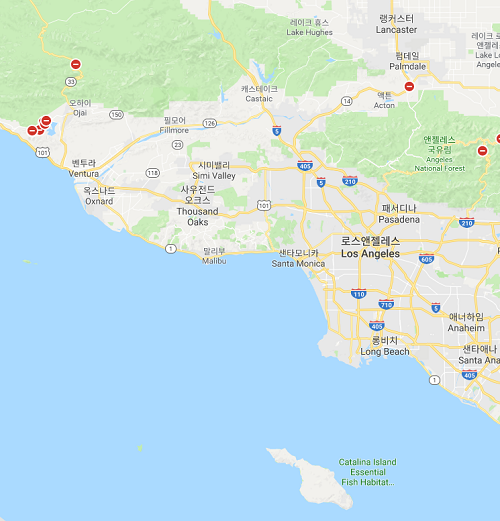

### properteis_2016 : parcelid count
properties_2016의 parcelid 중복 여부 검사

In [ ]:
# properties_2016의 parcelid는 모두 한 번씩만 등장한다
prop_cnt = properties_2016['parcelid'].value_counts().sort_values(ascending=True).reset_index()
prop_cnt[prop_cnt['parcelid'] > 1]

### merge : train_2016 and properties_2016
train, properties 두 테이블 병합하기
 - train_2016 : 90,811 rows
 - properteis_2016 : 2,985,217 rows

In [ ]:
# pandas의 merge는 sql의 join과 동일(디폴트로 inner join)하다. 여기선 left outer join을 수행한다.
merge_2016 = pd.merge(left=train_2016, right=properties_2016, on='parcelid', how='left')
print(merge_2016.shape)
merge_2016.head()

In [ ]:
# 2017년 데이터에 대해서도 똑같이 join dataframe을 만든다
merge_2017 = pd.merge(left=train_2017, right=properties_2017, on='parcelid', how='left')
print(merge_2017.shape)
merge_2017.head()

### merge : data type
병합한 데이터프레임의 데이터 타입 검사하기

In [ ]:
pd.options.display.max_rows = 65  # 데이터프레임 화면 출력 시 최대 row 수 조정

# 병합한 데이터프레임의 각 칼럼 데이터 타입 출력
dtype_merge_2016 = merge_2016.dtypes.reset_index()
dtype_merge_2016.columns = ['Column_Name', 'Column_Type']
dtype_merge_2016

In [ ]:
# 데이터 타임 별 개수 세기
dtype_merge_2016.groupby('Column_Type').agg('count').reset_index()

### merge : Nulls values
병합한 데이터프레임에서 Null(None, NaN) 값인 데이터 수 파악하기

In [ ]:
missing_merge_2016 = merge_2016.isnull().sum(axis=0).reset_index()  # 칼럼 별 NaN값 개수 세기
missing_merge_2016.columns = ['Column_Name', 'Missing_Count']
missing_merge_2016['Missing_Ratio'] = missing_merge_2016['Missing_Count'] / merge_2016.shape[0]
missing_merge_2016.ix[missing_merge_2016['Missing_Ratio'] > 0.999]

위의 네 개 feature들은 Null 값의 비율이 99.9%가 넘는다

### merge : float type values relation
병합된 데이터프레임의 float 값들 사이 연관관계를 분석해보자

상관계수 공식
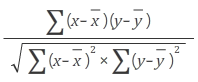
numpy의 corrcoef 함수는 -1 ~ 1 사이의 값들로 구성된 correlation 계수를 구한다
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html

병합된 데이터프레임의 각 feature들에 대해 logerror와의 상관계수를 계산하고 높은 것들을 선별해보자

In [ ]:
mean_values = merge_2016.mean(axis=0)  # 각 칼럼들의 평균값 구하기
# Null 값들을 평균치로 채워넣기 (data type이 object인 칼럼은 적용 안 됨. 여전히 Null값임)
merge_2016_new = merge_2016.fillna(mean_values, inplace=False)  # inplace=True면 merge_2016에도 fillna 적용됨

# 칼럼 리스트 추출. logerror이외의 칼럼 중 float64 타입인 칼럼들 이름을 리스트로 추출한다. (object 등 Null 값 가지는 것들은 제외된다)
x_cols = [col for col in merge_2016_new.columns if col not in ['logerror'] if merge_2016_new[col].dtype=='float64']

# 2017년 데이터에 대해서도 똑같은 작업
mean_values_2017 = merge_2017.mean(axis=0)  # 각 칼럼들의 평균값 구하기
# Null 값들을 평균치로 채워넣기 (data type이 object인 칼럼은 적용 안 됨. 여전히 Null값임)
merge_2017_new = merge_2017.fillna(mean_values_2017, inplace=False)  # inplace=True면 merge_2016에도 fillna 적용됨


In [ ]:
# Null 값들이 각 칼럼의 평균치로 채워진 merge_2016_new 데이터프레임
merge_2016_new.isnull().sum(axis=0)

데이터 타입이 object인 두 칼럼은 평균치가 따로 없으므로 여전히 Null 값인 상태이다.

In [ ]:
merge_2017_new.isnull().sum(axis=0)

In [ ]:
# Null 값을 평균치로 대체한 merge_2016_new의 칼럼별 logerror와의 correlation 값 계산해보자
labels = []
values = []
for col in x_cols:
    labels.append(col)
    # np.corrcoef(x, y) : x와 y의 correlation 배열을 반환. 2x2 배열로, 여기서 [0, 1] 포지션을 취한다.
    # 해당 값의 의미는 x_cols의 각 칼럼들의 logerror와의 관계 계수를 의미한다.
    values.append(np.corrcoef(merge_2016_new[col].values, merge_2016_new.logerror.values)[0, 1])
corr_2016 = pd.DataFrame({'col_labels':labels, 'corr_values':values})  # correlation dataframe 생성
corr_2016 = corr_2016.sort_values(by='corr_values')  # corr_value 기준 정렬
corr_2016  # 각 칼럼의 logerror와의 상관계수를 데이터프레임으로 나타낸 것

하위 8개 칼럼은 유니크한 한 값만 가져서 correlation 값을 구할 수 없다. 아래의 예시 참조

In [ ]:
merge_2016_new[['buildingclasstypeid', 'decktypeid', 'poolcnt', 'pooltypeid10', 
                'pooltypeid2', 'pooltypeid7', 'storytypeid', 'assessmentyear']].head(10)

In [ ]:
# 유니크한 값의 개수가 모두 1개씩이다.
corr_zero_cols = ['buildingclasstypeid', 'decktypeid', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid', 'assessmentyear']
for col in corr_zero_cols:
    print(col, len(merge_2016_new[col].unique()))

위에서 구한 logerror와의 correlation 값들을 시각화해보자

In [ ]:
# correlation 값들을 시각화하기
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,15))
rects = ax.barh(ind, np.array(corr_2016.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_2016.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

### merge : analysis with high correlation values
상관계수 절대값이 높은 feature들을 뽑아 분석해보자

In [ ]:
# 상관계수가 0에서 멀리 떨어진 feature들을 추출
corr_2016_sel = corr_2016.ix[(corr_2016['corr_values'] > 0.02) | (corr_2016['corr_values'] < -0.01)]
corr_2016_sel

위의 feature들은 상대적으로 logerror와의 연관성이 높다. 이번에는 위 feature들 상호 간의 연관성을 분석해보자

In [ ]:
cols_to_use = corr_2016_sel.col_labels.tolist()  # 위에서 추출한 feature들 이름들로 구성된 리스트

temp_df = merge_2016_new[cols_to_use]  # merge_2016_new에서 위 칼럼들만 추출
corrmat = temp_df.corr(method='spearman')  # 칼럼 간의 correlation 수치를 계산한 데이터프레임 반환

f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=1., vmin=-1., square=True)  # heatmap은 correlation 데이터프레임을 시각화하는데 사용됨
plt.title('Important variables correlation map')
plt.show()

위의 feature들은 대체로 서로에 대한 상관관계가 높다는 것을 알 수 있다. 상관관계 수치가 높은 feature부터 차례대로 살펴보자

### feature1 : finished square feet 12
상관계수가 가장 높은 finishedsquarefeet12 feature와 logerror의 관계를 분석해보자

In [ ]:
# finishedsquarefeet12 칼럼의 상한, 하한을 정한다
col_fsf = "finishedsquarefeet12"
fsf_ulimit = np.percentile(merge_2016_new[col_fsf].values, 99.5)
fsf_llimit = np.percentile(merge_2016_new[col_fsf].values, 0.5)
merge_2016_new[col_fsf].ix[merge_2016_new[col_fsf] > fsf_ulimit] = fsf_ulimit
merge_2016_new[col_fsf].ix[merge_2016_new[col_fsf] < fsf_llimit] = fsf_llimit

print("fsf_ulimit : ", fsf_ulimit)
print("fsf_llimit : ", fsf_llimit)

# finishedsquarefeet12의 값과 logerror의 값 분포를 시각화한다
plt.figure(figsize=(12,12))
sns.jointplot(x=merge_2016_new.finishedsquarefeet12.values, 
              y=merge_2016_new.logerror.values, size=10, color='y')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

logerror의 값의 범위는 finishedsquarefeet12의 값이 증가함에 따라 좁아진다는 것을 알 수 있다.

### feature2 : calculated finished square feet
calculatedfinishedsquarefeet feature와 logerror의 관계를 분석해보자

In [ ]:
# calculatedfinishedsquarefeet 칼럼의 상한, 하한을 정한다
col_cfsf = "calculatedfinishedsquarefeet"
cfsf_ulimit = np.percentile(merge_2016_new[col_cfsf].values, 99.5)
cfsf_llimit = np.percentile(merge_2016_new[col_cfsf].values, 0.5)
merge_2016_new[col_cfsf].ix[merge_2016_new[col_cfsf] > cfsf_ulimit] = cfsf_ulimit
merge_2016_new[col_cfsf].ix[merge_2016_new[col_cfsf] < cfsf_llimit] = cfsf_llimit

print('cfsf_ulimit : ', cfsf_ulimit)
print('cfsf_llimit : ', cfsf_llimit)

# calculatedfinishedsquarefeet의 값과 logerror의 값 분포를 시각화한다
plt.figure(figsize=(12,12))
sns.jointplot(x=merge_2016_new.calculatedfinishedsquarefeet.values, 
              y=merge_2016_new.logerror.values, size=10, color='b')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

calculatedfinishedsquarefeet도 앞과 마찬가지로 값이 커질 수록 logerror의 범위가 좁혀진다.

### feature3 : Bathroom count
bathroomcnt와 logerror의 관계를 분석해보자

In [ ]:
# 먼저 bathroomcnt의 값의 빈도수를 먼저 시각화하여 확인해보자
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=merge_2016_new)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

화장실이 2개인 경우가 가장 많은 것을 알 수 있다. 이제 이 bathroomcnt 칼럼과 logerror의 관계를 분석해보자

In [ ]:
# boxplot을 이용해 두 feature의 관계를 시각화해보자
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=merge_2016_new)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

seaborn의 boxplot은 box-whisker's plot(상자수염그림)으로 데이터를 시각화한다. 데이터에 대한 사분위값(Q1, Q2, Q3)을 구하고 Q1~Q3을 높이로 하는 사각형을 그린다.(가운데 선분은 Q2 지점) Q3~Q1 사이 거리를 IQR이라 할 때, 1.5 x IQR 값만금 Q1, Q3에서 벗어난 구간까지를 직선을 잇는다.(whisker) 이 직선을 벗어난 위치의 값들은 점이나 도형 등으로 따로 표현한다. 즉, 상자수염그림이 짧게 형성될 수록, whisker 범위 밖의 점들이 적을 수록 logerror 값들이 밀집해있다는 것을 알 수 있다.

### feature4 : Bedroom count
bedroomcnt와 logerror의 관계를 분석해보자 (bathroomcnt와 마찬가지로..)

In [ ]:
# 침실 수의 빈도 수를 시각화해보자
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=merge_2016_new)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

In [ ]:
# 침실 수와 logerror의 상관관계를 시각화해보자
merge_2016_new['bedroomcnt'].ix[merge_2016_new['bedroomcnt'] > 7] = 7  # 침실 수 7개를 넘으면 7로 통일한다.
plt.figure(figsize=(12,10))
sns.violinplot(data=merge_2016_new, x='bedroomcnt', y='logerror')
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

### feature5 : yearbuilt
지어진 연도와 logerror의 관계를 분석해보자

In [ ]:
plt.figure(figsize=(12,10))
sns.jointplot(x=merge_2016_new.yearbuilt.values, y=merge_2016_new.logerror.values, size=20)
plt.ylabel('logerror', fontsize=20)
plt.xlabel('yearbuilt', fontsize=20)
plt.show()

위 그래프에서 1900년대 중반 이후론 yearbuilt와 logerror 사이의 상관관계가 크다고 보기 어렵다.

### feature6 : heatingorsystemtypeid
상관계수가 음의 방향으로 높게 나온 feature와 logerror의 관계를 분석해보자

In [ ]:
# heatingorsystemtypeid의 값 분포를 시각화해보자
# hstid = merge_2016_new['heatingorsystemtypeid'].sort_values(ascending=True).values
plt.figure(figsize=(12, 8))
# plt.scatter(range(merge_2016_new.shape[0]), hstid)
sns.countplot(data=merge_2016_new, x='heatingorsystemtypeid')
plt.ylabel('Count')
plt.xlabel('heatingorsystemtypeid')
plt.show()

heatingorsystemtypeid의 값은 1~24의 값을 가지며 대부분 2.0이다. 3.926...은 Null 값을 평균치도 대체한 결과이다.

In [ ]:
plt.figure(figsize=(12,10))
sns.jointplot(data=merge_2016_new, x='heatingorsystemtypeid', y='logerror', size=10)
plt.ylabel('logerror')
plt.xlabel('heatingorsystemtypeid')
plt.show()

heatingorsystemtypeid의 값이 13~20일 때 logerror 값이 보다 0에 집중되는 것으로 파악된다.

### feature7 : taxamount
음의 방향으로 가장 상관계수가 높은 feature와 logerror의 관계를 분석해보자

In [ ]:
# taxamount 값의 분포를 시각화해보자
taxvalues = merge_2016_new.taxamount.sort_values().values
plt.figure(figsize=(8, 8))
plt.scatter(range(merge_2016_new.shape[0]), taxvalues)
plt.ylabel('tax amount')
plt.xlabel('index')
plt.show()

값의 분포에 상한, 하한을 두어 전처리를 해보자

In [ ]:
# tax amount에 상한, 하한 적용하기
txa = "taxamount"
txa_ulimit = np.percentile(merge_2016_new[txa].values, 99.5)
txa_llimit = np.percentile(merge_2016_new[txa].values, 0.5)
merge_2016_new[txa].ix[merge_2016_new[txa] > txa_ulimit] = txa_ulimit
merge_2016_new[txa].ix[merge_2016_new[txa] < txa_llimit] = txa_llimit

print('txa_ulimit : ', txa_ulimit)
print('txa_llimit : ', txa_llimit)

In [ ]:
# tax amount와 logerror의 관계를 jointplot으로 시각화해보자
plt.figure(figsize=(12,12))
sns.jointplot(x=merge_2016_new['taxamount'].values, y=merge_2016_new['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

taxamount 값이 커질수록 logerror의 값 범위가 좁아지는 것을 확인할 수 있다.

### feature8 : latitude and longitude
위도와 경도가 logerror와 어떤 관계가 있는지 분석해보자

In [ ]:
# ggplot은 점, 선, 막대 등 기하학적 객체들을 미적 특성으로 매핑하여 시각화해준다.
from ggplot import *
ggplot(aes(y='latitude', x='longitude', color='logerror'), data=merge_2016_new) +\
    geom_point() +\
    scale_color_gradient(low = 'red', high = 'yellow')

위도와 경도에 따른 logerror의 고저는 큰 연관성이 있다고 보기 어렵다.

### feature9 : taxamount and finishedsquarefeet12
각각 양과 음의 방향으로 상관계수가 높은 두 feature에 대해 logerror와의 관계를 동시에 분석해보자

In [ ]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=merge_2016_new) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'blue', high = 'red')

역시 두 feature와 logerror 고저의 큰 상관관계를 찾긴 어렵다. finishedsquarefeet12의 1700 근처 지점에서 생긴 직선은 Null 값을 평균치로 대체하면서 생긴 것이다.

### Non-linear model
비선형 모델(extra-tree regressor)을 이용하여 feature들의 중요도를 파악해보자

In [ ]:
train_y = merge_2016_new['logerror'].values  # logerror 값들의 리스트

# data type이 object인 5개 칼럼은 제거한다.
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]

# 분석 대상인 feature들만 남기고 나머지 칼럼들은 drop시킨다.
features_df = merge_2016_new.drop(['parcelid', 'logerror', 'transactiondate', 'transactionmonth']+cat_cols, axis=1)
feat_names = features_df.columns.values

from sklearn import ensemble
# extra-trees regressor는 결정트리들로 평균을 구하고 예측정확도를 높이는 모델이다.
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(features_df, train_y)  # 분석 대상 컬럼들과 그에 대한 logerror로 모델을 학습시킨다.

## plot the importances ##
importances = model.feature_importances_  # feature별 중요도 수치를 계산하여 배열로 반환
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)  # std : 표준화된 편차를 계산
# argsort는 값들을 정렬했을때 각 값의 인덱스를 배열로 반환함
indices = np.argsort(importances)[::-1][:20]  # argsort의 결과를 역순으로 뒤집고 앞에서 20개까지만 indices에 저장
# 즉, indices는 feature들의 중요도를 높은 순으로 정렬했을때의 각 feature들의 인덱스 값들을 배열로 한 것.

plt.figure(figsize=(12,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
smallist = ['a', 'b', 'c']
myfeatures = feat_names[indices][:10].tolist()
res = myfeatures + smallist
res

extra-trees regressor 비선형 모델에 의하면 각 feature 중 가장 중요도가 높은 것은 taxamont, structure tax value dollar count, land tax value dollor count 순으로 top3임을 알 수 있다.

## 3. Building Model
모델 설계를 위한 학습셋, 테스트셋을 만들고 모델을 학습시켜보자

* logerror와 연관성이 높은 상위 feature들을 선별한다.
* transactiondate의 year, month 정보만 추출하여 위 feature들과 함께 학습셋으로 사용한다.
* 테스트셋의 경우, year, month 칼럼에 201610~201712의 정보를 한번씩 넣어 예측 결과를 얻고, 얻은 결과를 한 데이터프레임으로 통합하자

### train set
* X_train_2016, Y_train_2016
* X_train_2017, Y_train_2017

In [ ]:
# 연도 칼럼 추가
merge_2016_new['transactionyear'] = merge_2016_new['transactiondate'].dt.year
merge_2017_new['transactionyear'] = merge_2017_new['transactiondate'].dt.year

In [ ]:
# 학습셋 X 준비
train_features = myfeatures + ['transactionyear', 'transactionmonth']  # 학습에 사용할 feature들

X_train_2016 = merge_2016_new[train_features]  # 학습용 데이터셋
print(X_train_2016.shape)

X_train_2017 = merge_2017_new[train_features]  # 학습용 데이터셋
print(X_train_2017.shape)

In [ ]:
X_train_2016.info()

In [ ]:
X_train_2016.info()

In [ ]:
# 학습셋 Y(label) 준비
Y_train_2016 = merge_2016_new[['logerror']]
print(Y_train_2016.shape)

Y_train_2017 = merge_2017_new[['logerror']]
print(Y_train_2017.shape)

In [ ]:
Y_train_2016.info()

In [ ]:
Y_train_2017.info()

### test set
* test_2016

In [ ]:
# submission 데이터프레임에서 parcelid만 추출하여 properties와 join한다
submission_df = sample_submission[['ParcelId']].rename(columns={'ParcelId':'parcelid'})  # 칼럼만 추출
test_2016 = pd.merge(left=submission_df, right=properties_2016, on='parcelid', how='left')  # join
test_2016 = test_2016[myfeatures]  # 선별된 feature만 사용
test_2016 = test_2016.fillna(test_2016.mean(axis=0))  # NaN 값 대체
test_2016['transactionyear'] = 2016  #  초기값은 2016이고 반복하면서 2017로 높인다
test_2016['transactionmonth'] = 1  #  초기값은 1이고 반복하면서 12까지 높인다

print('sample_submission : ', sample_submission.shape)
print('test_2016 : ', test_2016.shape)
test_2016.head()

In [ ]:
hello world~hello world!